# Australian Renewable Energy Generation


The aim of this project is to predict how much power a wind or solar farm will generate based on weather conditions.

Below is a time-series visualisation of renewable energy generation in Australia.


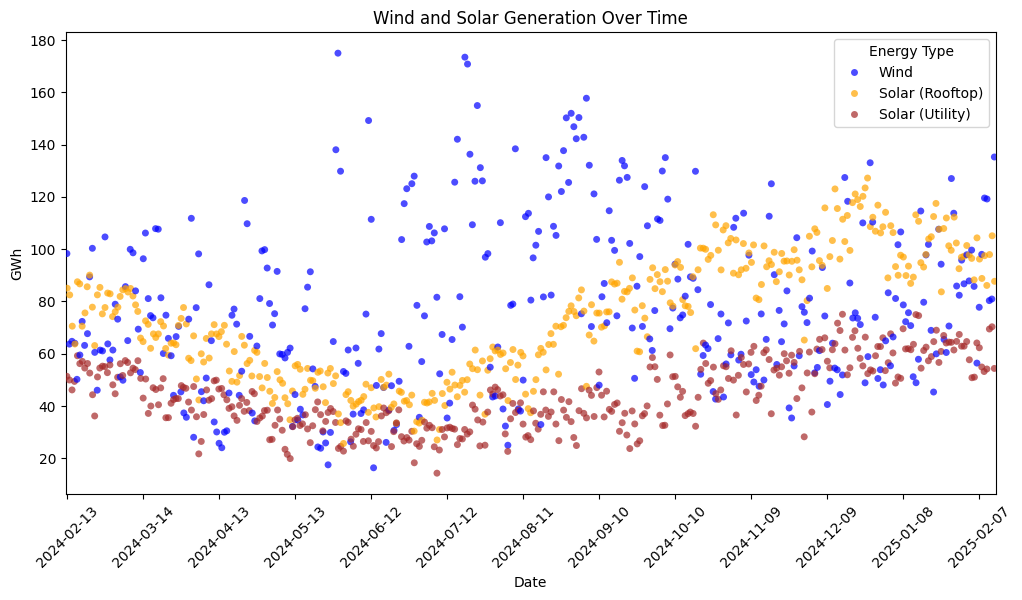

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

EnergyGeneration_df = pd.read_csv("2024EnergyGenerationAus.csv")
# print(EnergyGeneration_df.info())
# print(EnergyGeneration_df.describe())

# Visualizing the "Wind - GWh" and "Solar (Rooftop) - GWh" columns over time
# Ensure the date or time column is in datetime format & add DOY column
EnergyGeneration_df['Date'] = pd.to_datetime(EnergyGeneration_df['date'])
EnergyGeneration_df['DOY'] = EnergyGeneration_df['Date'].dt.dayofyear

# Reshape data to long format for Wind and Solar
EnergyGeneration_df_long = EnergyGeneration_df.melt(
    id_vars='Date', 
    value_vars=['Wind -  GWh', 'Solar (Rooftop) -  GWh', 'Solar (Utility) -  GWh'], 
    var_name='Energy Type', 
    value_name='GWh'
)

# Simplify energy type labels
EnergyGeneration_df_long['Energy Type'] = EnergyGeneration_df_long['Energy Type'].str.replace(' -  GWh', '')

# Plot using stripplot
plt.figure(figsize=(12, 6))
sns.stripplot(
    x='Date', 
    y='GWh', 
    hue='Energy Type', 
    data=EnergyGeneration_df_long, 
    jitter=True, 
    alpha=0.7, 
    palette={'Wind': 'blue', 'Solar (Rooftop)': 'orange', 'Solar (Utility)': 'brown'}
)

# Adding plot labels and title
plt.title('Wind and Solar Generation Over Time')
plt.xlabel('Date')
plt.ylabel('GWh')
plt.xticks(rotation=45)
plt.legend(title='Energy Type')
plt.xticks(ticks=plt.xticks()[0][::30], rotation=45)

# Show plot
plt.show()

Use OpenElectricity API to get historic QLD wind & solar data.

In [13]:
import os
import requests
import pandas as pd

# Define the API endpoint and parameters
api_url = "https://api.openelectricity.org.au/v4/data/network/NEM/"
params = {
    "interval": "1d",
    "date_start": "2024-02-13",
    "date_end": "2025-02-12",
    "primary_grouping": "network_region",
    "metrics": "energy",
    "secondary_grouping": "fueltech_group"
}

# Fetch the data from the API
response = requests.get(api_url, params=params)
data = response.json()

# Filter for Queensland's solar and wind energy data
solar_data = []
wind_data = []

for item in data['data']:  # Iterate through the 'data' list
    for result in item['results']:  # Now access 'results'
        if result['columns']['network_region'] == 'QLD1':
            if result['columns']['fueltech_group'] == 'solar':
                for entry in result['data']:
                    solar_data.append({'Date': entry[0], 'Solar (Utility) - GWh': entry[1] / 1000})
            elif result['columns']['fueltech_group'] == 'wind':
                for entry in result['data']:
                    wind_data.append({'Date': entry[0], 'Wind - GWh': entry[1] / 1000})

# Convert to DataFrames
solar_df = pd.DataFrame(solar_data)
wind_df = pd.DataFrame(wind_data)

# Merge data on Date
EnergyGeneration_df = pd.merge(solar_df, wind_df, on='Date', how='outer')
EnergyGeneration_df['Date'] = pd.to_datetime(EnergyGeneration_df['Date'])
EnergyGeneration_df['DOY'] = EnergyGeneration_df['Date'].dt.dayofyear

# # Define the CSV file path
# csv_path = os.path.join("SavedData", "PastEnergyGeneration.csv")

# # Ensure the "SavedData" directory exists
# os.makedirs("SavedData", exist_ok=True)

# # Load existing data if the CSV file exists
# if os.path.exists(csv_path):
#     existing_data_df = pd.read_csv(csv_path, parse_dates=['Date'])
# else:
#     existing_data_df = pd.DataFrame()

# # Append only new records
# if not existing_data_df.empty:
#     combined_df = pd.concat([existing_data_df, EnergyGeneration_df]).drop_duplicates(subset='Date', keep='last')
# else:
#     combined_df = EnergyGeneration_df

# # Save the updated DataFrame to CSV
# combined_df.to_csv(csv_path, index=False)


Use NASA POWER API to get weather parameters for solar and wind generation in Queensland

In [14]:
import pandas as pd
import numpy as np
import concurrent.futures
from api_fetch import fetch_weather_data

# Define Queensland's approximate lat/lon bounds for general parameters
latitudes = np.arange(-29, -10, 2)   # South QLD (-29) to North (-10) in 2-degree steps
longitudes = np.arange(138, 154, 2)  # West QLD (138) to East Coast (154) in 2-degree steps

# Define specific wind farm coordinates (latitude, longitude)
wind_farm_coords = [
    (-26.55, 151.33),  # Coopers Gap Wind Farm
    (-26.80, 150.27),  # Dulacca Wind Farm
    (-17.2, 145.4),    # Mount Emerald Wind Farm
    (-17.5922, 145.5306),  # Windy Hill Wind Farm
    (-17.06, 146.75),  # Kaban Green Power Hub
    (-21, 145)         # Kennedy Energy Park
]

# Parameters for weather data
parameters = "T2M,ALLSKY_SFC_SW_DWN,WS50M,WS50M_MAX,WS10M_MAX,CLOUD_AMT,QV2M"       # Temperature, Solar Radiation, Wind Speed at 50m and its maximum, cloud cover and humidity
start_date = "20240213"
end_date = "20250212"

# Store results
all_data = []

# Function to fetch weather data for a given set of parameters and location
def fetch_loc_weatherData(lat, lon, parameters, isWindFarm=False):
    print(f"Fetching data for Lat: {lat}, Lon: {lon} with parameters: {parameters}...")
    data = fetch_weather_data(
        parameters=parameters,
        latitude=lat,
        longitude=lon,
        start_date=start_date,
        end_date=end_date
    )
    if data is not None:
        data["Latitude"] = lat
        data["Longitude"] = lon
        data["isWindFarm"] = isWindFarm  # Add the isWind column
        # Convert YEAR + DOY to datetime format
        data["Date"] = pd.to_datetime(data["YEAR"].astype(str) + data["DOY"].astype(str), format="%Y%j")
    return data

# Execute API calls concurrently
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    futures = []
    
    # Grid locations for non-wind parameters
    for lat in latitudes:
        for lon in longitudes:
            futures.append(executor.submit(
                fetch_loc_weatherData, lat, lon, parameters, isWindFarm=False
            ))
    
    # Wind farm locations for wind parameters
    for lat, lon in wind_farm_coords:
        futures.append(executor.submit(
            fetch_loc_weatherData, lat, lon, parameters, isWindFarm=True
        ))
    
    # Collect results
    for future in concurrent.futures.as_completed(futures):
        result = future.result()
        if result is not None:
            all_data.append(result)

# Combine all results into a single DataFrame
if all_data:
    WeatherData_df = pd.concat(all_data, ignore_index=True)
    print(WeatherData_df.head())
else:
    print("No data retrieved.")

# Data Cleaning
# Remove rows with invalid values
invalid_value = -999
WeatherData_df = WeatherData_df.replace(invalid_value, np.nan).dropna()

# Drop rows in EnergyGeneration_df if no corresponding date in WeatherData_df
EnergyGeneration_clean_df = EnergyGeneration_df[EnergyGeneration_df['Date'].isin(WeatherData_df['Date'])]


Fetching data for Lat: -29, Lon: 138 with parameters: T2M,ALLSKY_SFC_SW_DWN,WS50M,WS50M_MAX,WS10M_MAX,CLOUD_AMT,QV2M...
Fetching data for Lat: -29, Lon: 140 with parameters: T2M,ALLSKY_SFC_SW_DWN,WS50M,WS50M_MAX,WS10M_MAX,CLOUD_AMT,QV2M...
Fetching data for Lat: -29, Lon: 142 with parameters: T2M,ALLSKY_SFC_SW_DWN,WS50M,WS50M_MAX,WS10M_MAX,CLOUD_AMT,QV2M...
Fetching data for Lat: -29, Lon: 144 with parameters: T2M,ALLSKY_SFC_SW_DWN,WS50M,WS50M_MAX,WS10M_MAX,CLOUD_AMT,QV2M...
Fetching data for Lat: -29, Lon: 146 with parameters: T2M,ALLSKY_SFC_SW_DWN,WS50M,WS50M_MAX,WS10M_MAX,CLOUD_AMT,QV2M...
Fetching data for Lat: -29, Lon: 148 with parameters: T2M,ALLSKY_SFC_SW_DWN,WS50M,WS50M_MAX,WS10M_MAX,CLOUD_AMT,QV2M...
Fetching data for Lat: -29, Lon: 150 with parameters: T2M,ALLSKY_SFC_SW_DWN,WS50M,WS50M_MAX,WS10M_MAX,CLOUD_AMT,QV2M...
Fetching data for Lat: -29, Lon: 152 with parameters: T2M,ALLSKY_SFC_SW_DWN,WS50M,WS50M_MAX,WS10M_MAX,CLOUD_AMT,QV2M...
Fetching data for Lat: -27, Lon: 138 wit

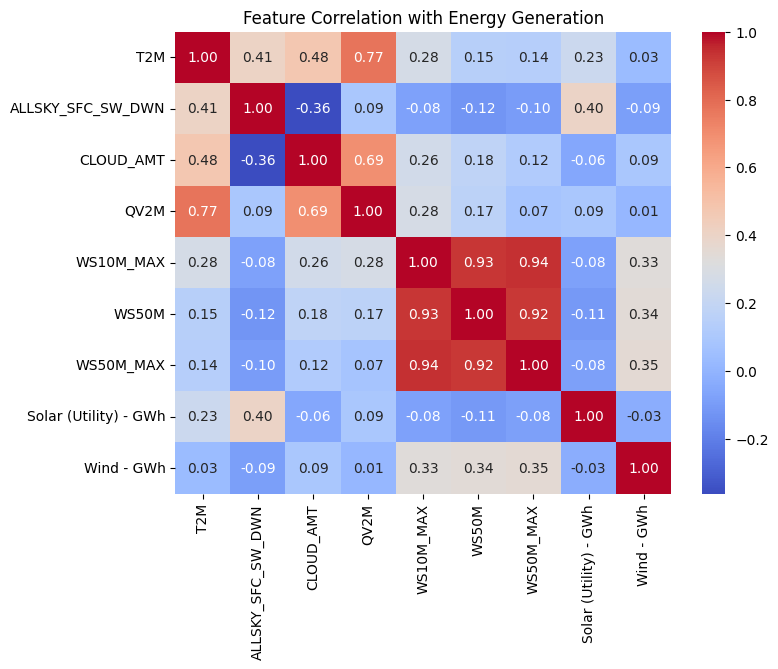

In [15]:
### Data Exploration: Check correlation between variables
import seaborn as sns
import matplotlib.pyplot as plt

# Merge WeatherData_df and EnergyGeneration_df on Date
merged_df = pd.merge(WeatherData_df, EnergyGeneration_clean_df, on="Date", how="inner")

# Select only relevant columns
# correlation_matrix = merged_df[["T2M", "WS50M", "WS50M_MAX", "WS10M_MAX", "ALLSKY_SFC_SW_DWN", "Solar (Utility) -  GWh", "Solar (Rooftop) -  GWh", "Wind -  GWh"]].corr()
correlation_matrix = merged_df[["T2M","ALLSKY_SFC_SW_DWN","CLOUD_AMT", "QV2M", "WS10M_MAX","WS50M", "WS50M_MAX", "Solar (Utility) - GWh", "Wind - GWh"]].corr()

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation with Energy Generation")
plt.show()


## Model Building
#### 1. Linear Regression

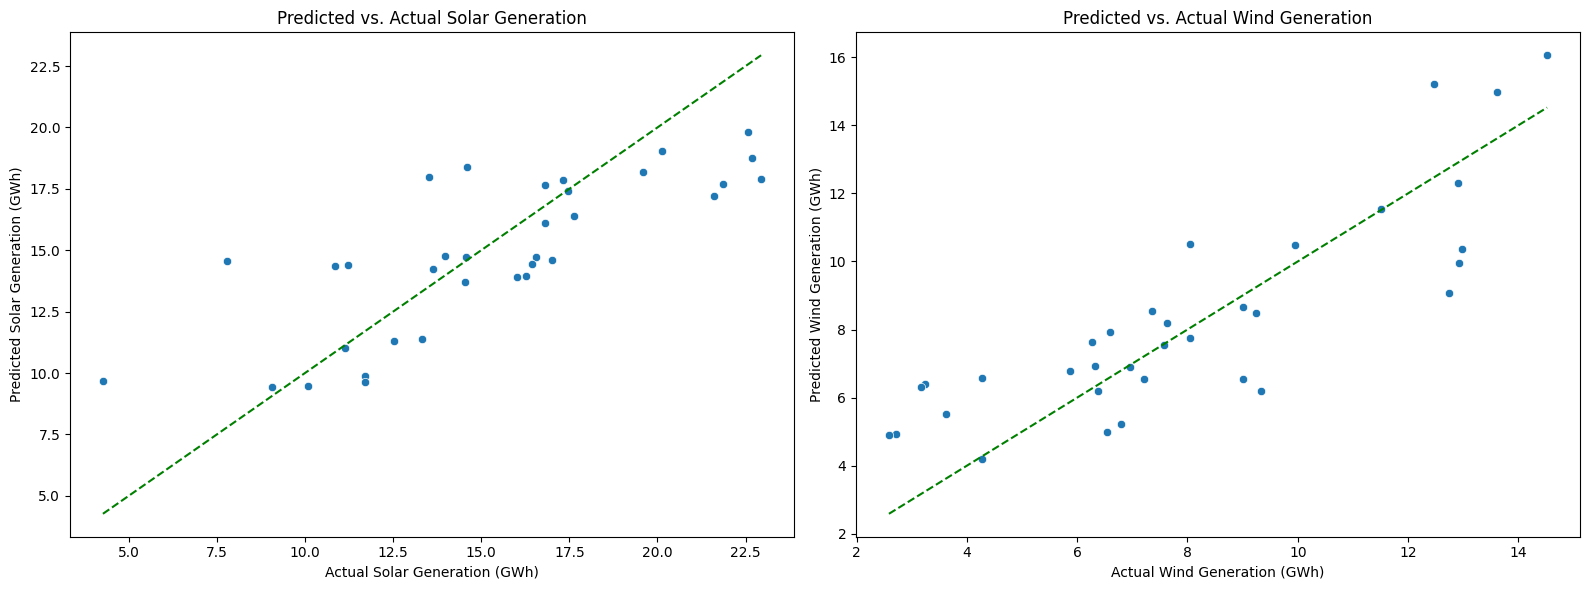

Solar MAE: 2.190583081037526
Wind MAE: 1.4913962202953417


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

## First, create model for solar energy generation: Solar (Rooftop + Utility) - GWh
# Features: temperature, solar radiation, DOY (for seasonality)

# Select the features for the model
WeatherData_avg = WeatherData_df.groupby('DOY')[['T2M', 'ALLSKY_SFC_SW_DWN', 'WS10M_MAX']].mean().reset_index() # Group by DOY and take the average for these parameters
EnergyGeneration_clean_df = EnergyGeneration_clean_df.sort_values(by='DOY')

X = WeatherData_avg[['T2M', 'ALLSKY_SFC_SW_DWN']]
# y = EnergyGeneration_clean_df['Solar (Utility) - GWh'] + EnergyGeneration_clean_df['Solar (Rooftop) - GWh']
y = EnergyGeneration_clean_df['Solar (Utility) - GWh']


# Data split, train model, predict
X_train, X_test, y_train, y_test_solar = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred_solar = model.predict(X_test)




## Second, create model for wind energy generation: Wind - GWh
# Features: wind speed

# Select the features for the model
WeatherData_wind = WeatherData_df[WeatherData_df['isWindFarm'] == True] # Just select data for wind farms
WeatherData_avg_wind = WeatherData_wind.groupby('DOY')[['WS10M_MAX']].mean().reset_index() # Group by DOY and take the average for wind speed
X = WeatherData_avg_wind[['WS10M_MAX']]  ** 3 # Wind generation is proportional to the cube of wind speed
y = EnergyGeneration_clean_df['Wind - GWh']

# Data split, train model, predict
X_train, X_test, y_train, y_test_wind = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred_wind = model.predict(X_test)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Solar plot
sns.scatterplot(x=y_test_solar, y=y_pred_solar, ax=axes[0])
axes[0].plot([y_test_solar.min(), y_test_solar.max()], [y_test_solar.min(), y_test_solar.max()], 'g--')  # Ideal 1:1 line
axes[0].set_xlabel("Actual Solar Generation (GWh)")
axes[0].set_ylabel("Predicted Solar Generation (GWh)")
axes[0].set_title("Predicted vs. Actual Solar Generation")

# Wind plot
sns.scatterplot(x=y_test_wind, y=y_pred_wind, ax=axes[1])
axes[1].plot([y_test_wind.min(), y_test_wind.max()], [y_test_wind.min(), y_test_wind.max()], 'g--')  # Ideal 1:1 line
axes[1].set_xlabel("Actual Wind Generation (GWh)")
axes[1].set_ylabel("Predicted Wind Generation (GWh)")
axes[1].set_title("Predicted vs. Actual Wind Generation")

plt.tight_layout()
plt.show()

print("Solar MAE:", mean_absolute_error(y_test_solar, y_pred_solar))
print("Wind MAE:", mean_absolute_error(y_test_wind, y_pred_wind))

##### Model Improvement Experiements
a. Incoorporate seasonality

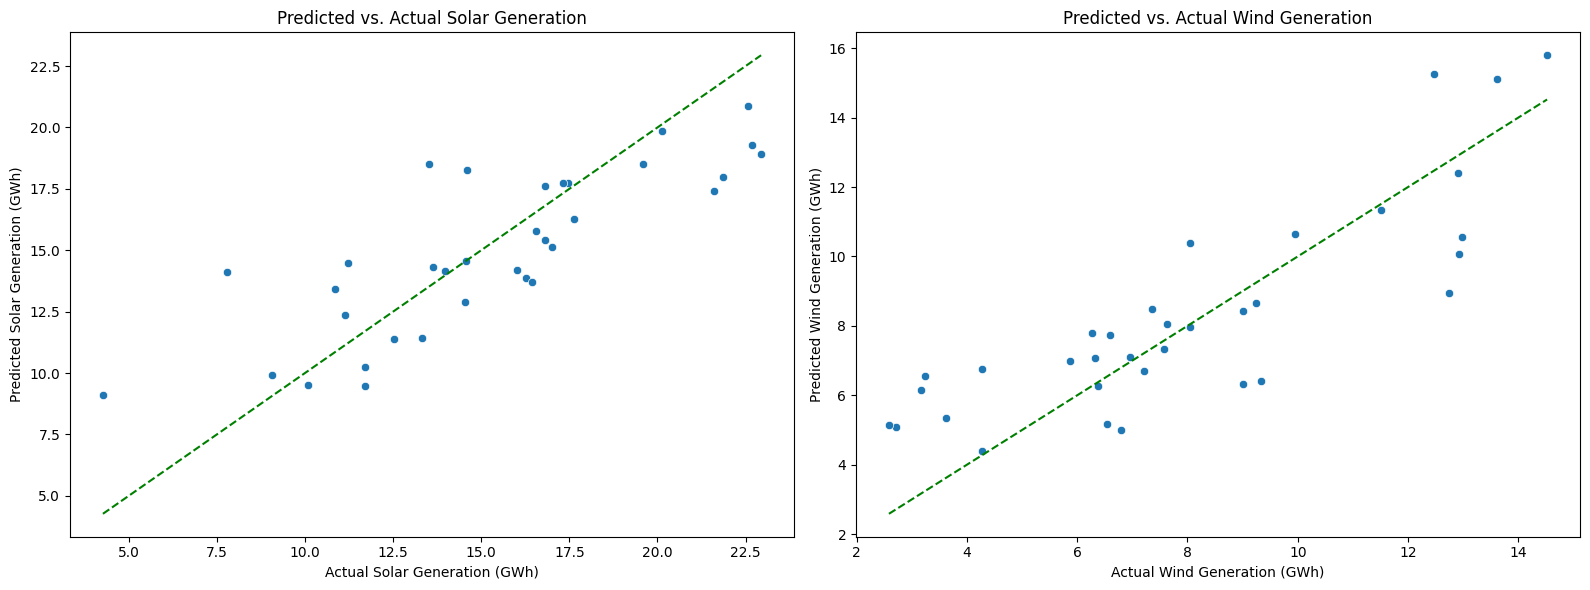

Solar MAE: 2.0562153586899767
Wind MAE: 1.4987509724679073


In [17]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

## First, create model for solar energy generation: Solar (Rooftop + Utility) - GWh
# Features: temperature, solar radiation, DOY (for seasonality)

# Select the features for the model
WeatherData_avg = WeatherData_df.groupby('DOY')[['T2M', 'ALLSKY_SFC_SW_DWN', 'WS50M_MAX', 'WS50M','WS10M_MAX']].mean().reset_index() # Group by DOY and take the average for these parameters
EnergyGeneration_clean_df = EnergyGeneration_clean_df.sort_values(by='DOY')

WeatherData_avg['DOY_sin'] = np.sin(2 * np.pi * WeatherData_avg['DOY'] / 365) # Encode DOY as sin/cos for seasonality
WeatherData_avg['DOY_cos'] = np.cos(2 * np.pi * WeatherData_avg['DOY'] / 365)

X = WeatherData_avg[['T2M', 'ALLSKY_SFC_SW_DWN' , 'DOY_sin', 'DOY_cos']]
# y = EnergyGeneration_clean_df['Solar (Utility) -  GWh'] + EnergyGeneration_clean_df['Solar (Rooftop) -  GWh']
y = EnergyGeneration_clean_df['Solar (Utility) - GWh']

# Data split, train model, predict
X_train, X_test, y_train, y_test_solar = train_test_split(X, y, test_size=0.2, random_state=42)

Solar_LR_model = LinearRegression()
Solar_LR_model.fit(X_train, y_train)
y_pred_solar = Solar_LR_model.predict(X_test)




## Second, create model for wind energy generation: Wind - GWh
# Features: wind speed

# Select the features for the model
WeatherData_wind = WeatherData_df[WeatherData_df['isWindFarm'] == True] # Just select data for wind farms
WeatherData_avg_wind = WeatherData_wind.groupby('DOY')[['WS10M_MAX']].mean().reset_index() # Group by DOY and take the average for wind speed
# Encode DOY as sine and cosine components to capture seasonality
WeatherData_avg_wind['DOY_sin'] = np.sin(2 * np.pi * WeatherData_avg_wind['DOY'] / 365)
WeatherData_avg_wind['DOY_cos'] = np.cos(2 * np.pi * WeatherData_avg_wind['DOY'] / 365)

# Select the features for the model, including DOY components and wind speed
X = WeatherData_avg_wind[['WS10M_MAX', 'DOY_sin', 'DOY_cos']] ** 3  # Wind generation is proportional to the cube of wind speed
y = EnergyGeneration_clean_df['Wind - GWh']

# Data split, train model, predict
X_train, X_test, y_train, y_test_wind = train_test_split(X, y, test_size=0.2, random_state=42)

Wind_LR_model = LinearRegression()
Wind_LR_model.fit(X_train, y_train)
y_pred_wind = Wind_LR_model.predict(X_test)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Solar plot
sns.scatterplot(x=y_test_solar, y=y_pred_solar, ax=axes[0])
axes[0].plot([y_test_solar.min(), y_test_solar.max()], [y_test_solar.min(), y_test_solar.max()], 'g--')  # Ideal 1:1 line
axes[0].set_xlabel("Actual Solar Generation (GWh)")
axes[0].set_ylabel("Predicted Solar Generation (GWh)")
axes[0].set_title("Predicted vs. Actual Solar Generation")

# Wind plot
sns.scatterplot(x=y_test_wind, y=y_pred_wind, ax=axes[1])
axes[1].plot([y_test_wind.min(), y_test_wind.max()], [y_test_wind.min(), y_test_wind.max()], 'g--')  # Ideal 1:1 line
axes[1].set_xlabel("Actual Wind Generation (GWh)")
axes[1].set_ylabel("Predicted Wind Generation (GWh)")
axes[1].set_title("Predicted vs. Actual Wind Generation")

plt.tight_layout()
plt.show()

print("Solar MAE:", mean_absolute_error(y_test_solar, y_pred_solar))
print("Wind MAE:", mean_absolute_error(y_test_wind, y_pred_wind))

#### 2. Gradient Boosting (XGBoost)

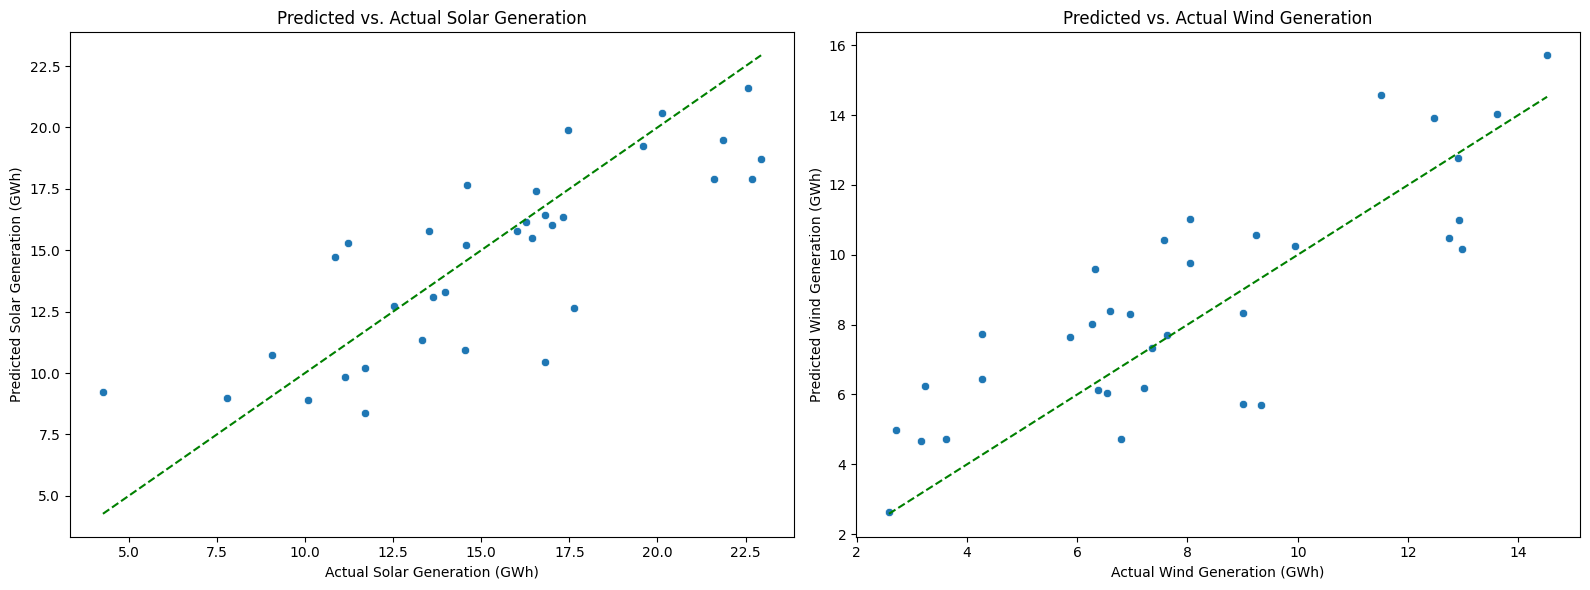

Solar MAE: 2.09082149096967
Wind MAE: 1.6904408485081395


In [18]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


## First, create model for solar energy generation: Solar (Rooftop + Utility) - GWh
# Features: temperature, solar radiation, DOY (for seasonality)

# Select the features for the model
WeatherData_avg = WeatherData_df.groupby('DOY')[['T2M', 'ALLSKY_SFC_SW_DWN', 'WS50M_MAX', 'WS50M', 'WS10M_MAX']].mean().reset_index() # Group by DOY and take the average for these parameters
EnergyGeneration_clean_df = EnergyGeneration_clean_df.sort_values(by='DOY')

WeatherData_avg['DOY_sin'] = np.sin(2 * np.pi * WeatherData_avg['DOY'] / 365)  # Encode DOY as sin/cos for seasonality
WeatherData_avg['DOY_cos'] = np.cos(2 * np.pi * WeatherData_avg['DOY'] / 365)

X_solar = WeatherData_avg[['T2M', 'ALLSKY_SFC_SW_DWN' , 'DOY_sin', 'DOY_cos']]
# y_solar = EnergyGeneration_clean_df['Solar (Utility) -  GWh'] + EnergyGeneration_clean_df['Solar (Rooftop) -  GWh']
y_solar = EnergyGeneration_clean_df['Solar (Utility) - GWh']

# Feature Scaling
scaler = StandardScaler()
X_solar_scaled = scaler.fit_transform(X_solar)

# Data split, train model, predict
X_train_solar, X_test_solar, y_train_solar, y_test_solar = train_test_split(X_solar_scaled, y_solar, test_size=0.2, random_state=42)

# Use XGBoost for Solar model
Solar_XG_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42)
Solar_XG_model.fit(X_train_solar, y_train_solar)
y_pred_solar = Solar_XG_model.predict(X_test_solar)






## Second, create model for wind energy generation: Wind - GWh
# Features: wind speed

# Select the features for the model
WeatherData_wind = WeatherData_df[WeatherData_df['isWindFarm'] == True]  # Just select data for wind farms
WeatherData_avg_wind = WeatherData_wind.groupby('DOY')[['WS10M_MAX']].mean().reset_index()  # Group by DOY and take the average for wind speed

# Encode DOY as sine and cosine components to capture seasonality
WeatherData_avg_wind['DOY_sin'] = np.sin(2 * np.pi * WeatherData_avg_wind['DOY'] / 365)
WeatherData_avg_wind['DOY_cos'] = np.cos(2 * np.pi * WeatherData_avg_wind['DOY'] / 365)

# Select the features for the model, including DOY components and wind speed
X_wind = WeatherData_avg_wind[['WS10M_MAX', 'DOY_sin', 'DOY_cos']] ** 3  # Wind generation is proportional to the cube of wind speed
y_wind = EnergyGeneration_clean_df['Wind - GWh']

# Feature Scaling
X_wind_scaled = scaler.fit_transform(X_wind)

# Data split, train model, predict
X_train_wind, X_test_wind, y_train_wind, y_test_wind = train_test_split(X_wind_scaled, y_wind, test_size=0.2, random_state=42)

# Use XGBoost for Wind model
Wind_XG_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42)
Wind_XG_model.fit(X_train_wind, y_train_wind)
y_pred_wind = Wind_XG_model.predict(X_test_wind)






# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Solar plot
sns.scatterplot(x=y_test_solar, y=y_pred_solar, ax=axes[0])
axes[0].plot([y_test_solar.min(), y_test_solar.max()], [y_test_solar.min(), y_test_solar.max()], 'g--')  # Ideal 1:1 line
axes[0].set_xlabel("Actual Solar Generation (GWh)")
axes[0].set_ylabel("Predicted Solar Generation (GWh)")
axes[0].set_title("Predicted vs. Actual Solar Generation")

# Wind plot
sns.scatterplot(x=y_test_wind, y=y_pred_wind, ax=axes[1])
axes[1].plot([y_test_wind.min(), y_test_wind.max()], [y_test_wind.min(), y_test_wind.max()], 'g--')  # Ideal 1:1 line
axes[1].set_xlabel("Actual Wind Generation (GWh)")
axes[1].set_ylabel("Predicted Wind Generation (GWh)")
axes[1].set_title("Predicted vs. Actual Wind Generation")

plt.tight_layout()
plt.show()

# Print performance metrics
print("Solar MAE:", mean_absolute_error(y_test_solar, y_pred_solar))
print("Wind MAE:", mean_absolute_error(y_test_wind, y_pred_wind))


#### 3. Seasonal Autoregressive Integrated Moving Average (SARIMA)

Uses energy generation history rather than weather variables (e.g. solar radiance, wind speed) to forecast solar & wind generation. Should be able to capture trends and seasonality.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# Convert to datetime and set as index
# EnergyGeneration_df = pd.read_csv("2024EnergyGenerationAus.csv")
# EnergyGeneration_df['Date'] = pd.to_datetime(EnergyGeneration_df['date'])
EnergyGeneration_df.set_index('Date', inplace=True)

# Prepare Solar Time Series
# solar_ts = EnergyGeneration_df['Solar (Utility) -  GWh'] + EnergyGeneration_df['Solar (Rooftop) -  GWh']
solar_ts = EnergyGeneration_df['Solar (Utility) - GWh']


# Prepare Wind Time Series
wind_ts = EnergyGeneration_df['Wind - GWh']



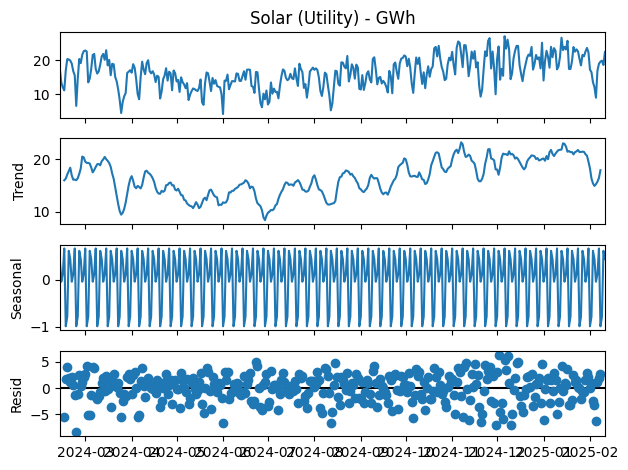

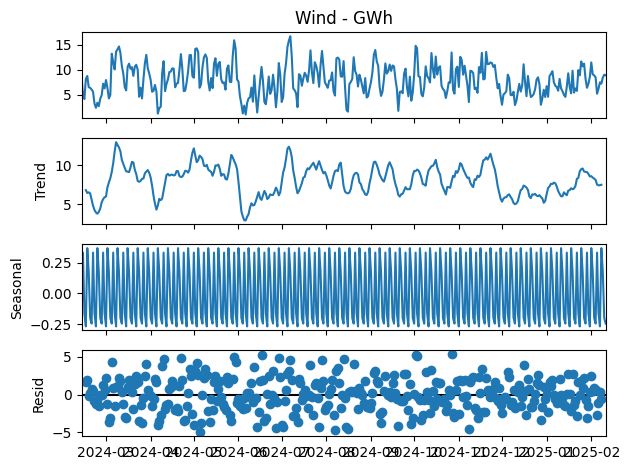

In [20]:
### Explore Time series to determine parameters for SARIMA model

## Check for seasonal differencing (D)
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose solar time series
result_solar = seasonal_decompose(solar_ts, model='additive')
result_solar.plot()

# Decompose wind time series
result_wind = seasonal_decompose(wind_ts, model='additive')
result_wind.plot()

plt.tight_layout()
plt.show()

## -- There is a clear seasonal trend for solar generation (12 month cycle) but not for wind generation -- ##

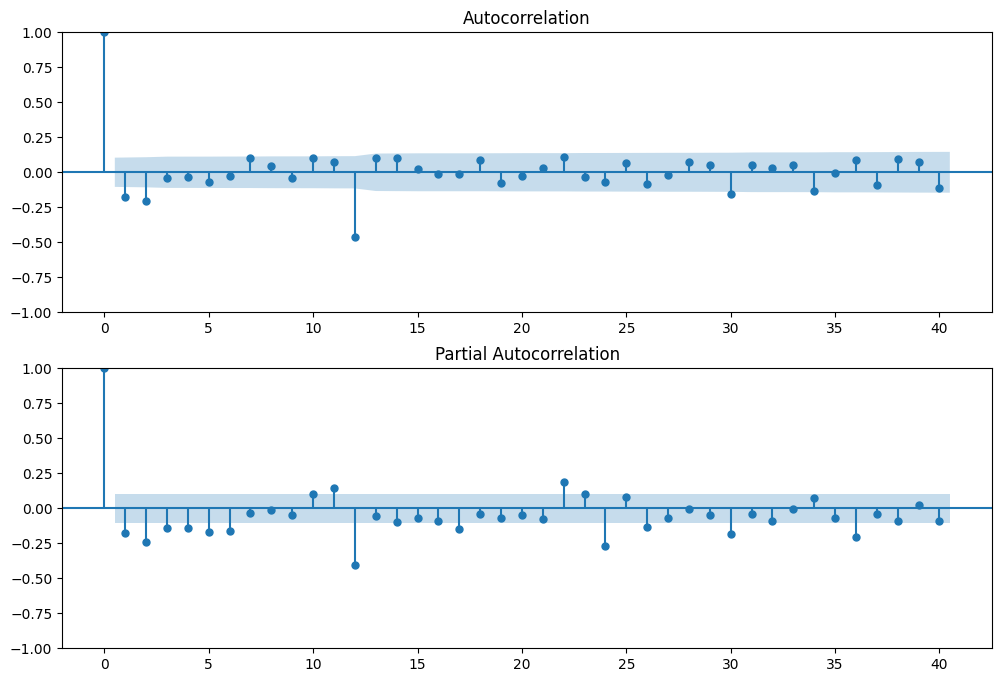

In [21]:
### For AR/MA order (p, q) determination, use ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Apply differencing
d = 1  
s = 12
D = 1 

stationary_series = solar_ts.diff(d).diff(s*D).dropna()

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(stationary_series, lags=40, ax=ax[0])
plot_pacf(stationary_series, lags=40, ax=ax[1], method='ywm')
plt.show()

c:\Users\Tom\Documents\Projects\Renewable-Energy-Generation-Prediction\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Tom\Documents\Projects\Renewable-Energy-Generation-Prediction\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Tom\Documents\Projects\Renewable-Energy-Generation-Prediction\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Tom\Documents\Projects\Renewable-Energy-Generation-Prediction\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  se

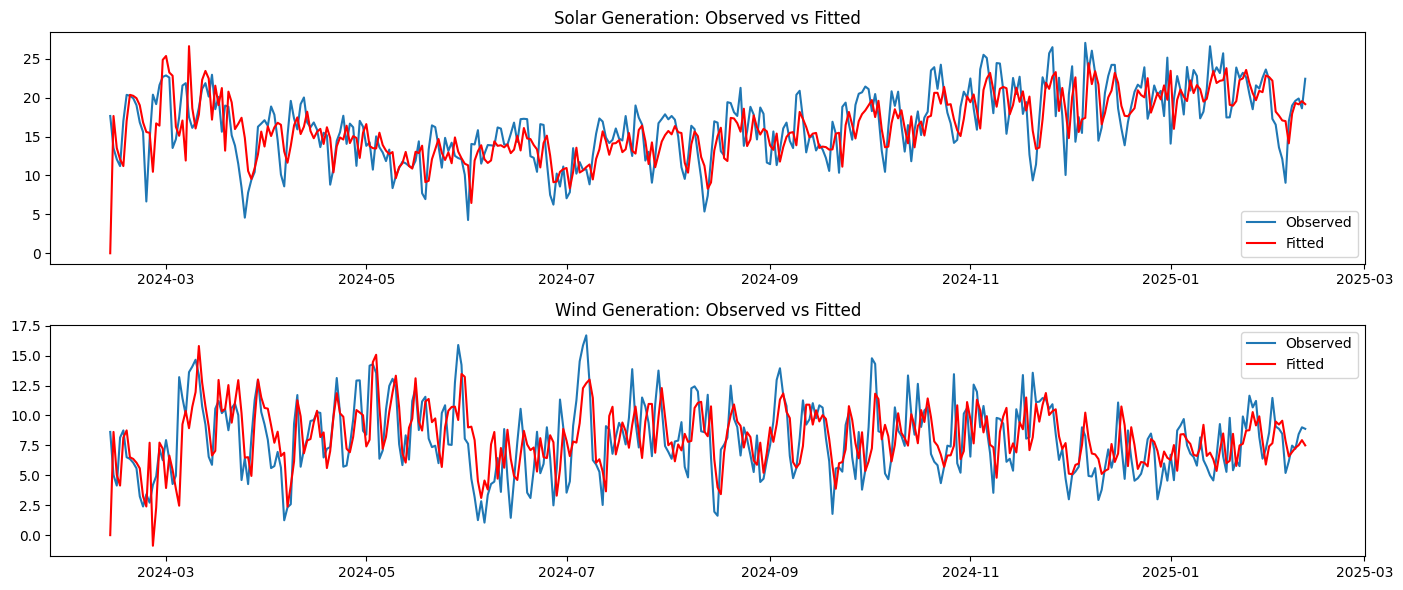

Solar MAE: 2.70 GWh
Wind MAE: 2.08 GWh


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# Define SARIMA parameters (initial guess)
p, d, q = 1, 1, 1  # Non-seasonal AR, differencing, MA orders
P, D, Q, s = 1, 1, 1, 12  # Seasonal AR, differencing, MA orders, and seasonality (12 months)

# Fit SARIMA model for Solar
Solar_SARIMA_model = SARIMAX(solar_ts, order=(p, d, q), seasonal_order=(P, D, Q, s))
solar_results = Solar_SARIMA_model.fit(disp=False)

# Fit SARIMA model for Wind
Wind_SARIMA_model = SARIMAX(wind_ts, order=(p, d, q), seasonal_order=(P, D, Q, s))
wind_results = Wind_SARIMA_model.fit(disp=False)

# Plot results for Solar
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.plot(solar_ts, label='Observed')
plt.plot(solar_results.fittedvalues, label='Fitted', color='red')
plt.title('Solar Generation: Observed vs Fitted')
plt.legend()

# Plot results for Wind
plt.subplot(2, 1, 2)
plt.plot(wind_ts, label='Observed')
plt.plot(wind_results.fittedvalues, label='Fitted', color='red')
plt.title('Wind Generation: Observed vs Fitted')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate model performance (using Mean Absolute Error)
solar_mae = mean_absolute_error(solar_ts, solar_results.fittedvalues)
wind_mae = mean_absolute_error(wind_ts, wind_results.fittedvalues)

print(f"Solar MAE: {solar_mae:.2f} GWh")
print(f"Wind MAE: {wind_mae:.2f} GWh")


## Energy Forecasts/Predictions

Forecasts for expected solar and wind energy generation in Queensland using 3 models:

In [ ]:
### ---- Get required weather data for prediction ---- ###
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"
params = {
	"latitude": -27.4679,
	"longitude": 153.0281,
	"hourly": ["temperature_2m", "wind_speed_180m", "shortwave_radiation"],
	"daily": ["temperature_2m_max", "wind_speed_10m_max", "shortwave_radiation_sum"],
	"wind_speed_unit": "ms",
	"timezone": "Australia/Sydney"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_wind_speed_180m = hourly.Variables(1).ValuesAsNumpy()
hourly_shortwave_radiation = hourly.Variables(2).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["wind_speed_180m"] = hourly_wind_speed_180m
hourly_data["shortwave_radiation"] = hourly_shortwave_radiation

hourly_dataframe = pd.DataFrame(data = hourly_data)
# print(hourly_dataframe)

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
daily_wind_speed_10m_max = daily.Variables(1).ValuesAsNumpy()
daily_shortwave_radiation_sum = daily.Variables(2).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}

daily_data["temperature_2m_max"] = daily_temperature_2m_max
daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
daily_data["shortwave_radiation_sum"] = daily_shortwave_radiation_sum

daily_dataframe = pd.DataFrame(data = daily_data)
print(daily_dataframe)


Coordinates -27.5°N 153.0°E
Elevation 27.0 m asl
Timezone b'Australia/Sydney' b'GMT+11'
Timezone difference to GMT+0 39600 s
                       date  temperature_2m_max  wind_speed_10m_max  \
0 2025-02-16 13:00:00+00:00           28.023001            4.177320   
1 2025-02-17 13:00:00+00:00           29.473001            3.773592   
2 2025-02-18 13:00:00+00:00           27.673000            3.601388   
3 2025-02-19 13:00:00+00:00           29.973001            4.492216   
4 2025-02-20 13:00:00+00:00           26.823000            4.640043   
5 2025-02-21 13:00:00+00:00           29.573000            5.300000   
6 2025-02-22 13:00:00+00:00           28.523001            4.588028   

   shortwave_radiation_sum  
0                20.660000  
1                21.590000  
2                21.049999  
3                24.760000  
4                19.200001  
5                22.990000  
6                15.700000  


##### Linear Regression

In [24]:
### Forecasting Energy Generation using linear regression
daily_dataframe['DOY'] = daily_dataframe['date'].dt.dayofyear
daily_dataframe['DOY_sin'] = np.sin(2 * np.pi * daily_dataframe['DOY'] / 365)
daily_dataframe['DOY_cos'] = np.cos(2 * np.pi * daily_dataframe['DOY'] / 365)

daily_dataframe['T2M'] = daily_dataframe['temperature_2m_max']
daily_dataframe['ALLSKY_SFC_SW_DWN'] = daily_dataframe['shortwave_radiation_sum']
daily_dataframe['WS10M_MAX'] = daily_dataframe['wind_speed_10m_max']


# -- Solar -- #
x = daily_dataframe[['T2M','ALLSKY_SFC_SW_DWN', 'DOY_sin', 'DOY_cos']]
y_pred_solarLR = Solar_LR_model.predict(x)


# -- Wind -- #
x = daily_dataframe[['WS10M_MAX', 'DOY_sin', 'DOY_cos']] ** 3
y_pred_windLR = Wind_LR_model.predict(x)


print("Solar Generation Prediction:", y_pred_solarLR)
print("Wind Generation Prediction:", y_pred_windLR)

Solar Generation Prediction: [16.23153892 17.8893174  16.70963094 22.30642315 14.06918027 19.89612213
  9.9209296 ]
Wind Generation Prediction: [5.40664495 4.93440053 4.76154177 5.84598302 6.07477905 7.28365153
 5.99465122]


##### Gradient Boosting

In [25]:
### Forecasting Energy Generation using linear regression
# -- Solar -- #
x = daily_dataframe[['T2M','ALLSKY_SFC_SW_DWN', 'DOY_sin', 'DOY_cos']]
y_pred_solarGB = Solar_XG_model.predict(x)


# -- Wind -- #
x = daily_dataframe[['WS10M_MAX', 'DOY_sin', 'DOY_cos']] ** 3
y_pred_windGB = Wind_XG_model.predict(x)


print("Solar Generation Prediction:", y_pred_solarGB)
print("Wind Generation Prediction:", y_pred_windGB)

Solar Generation Prediction: [21.610197 21.610197 21.610197 21.611534 21.611534 22.639008 22.61738 ]
Wind Generation Prediction: [14.783436 14.783436 14.783436 14.608476 14.608901 14.608901 14.589623]


##### SARIMA

In [26]:
# Perform SARIMA Forecasts
# -- Solar -- #
solar_forecast_sarima = solar_results.forecast(steps=7)  # Forecast for the next 12 periods (e.g., months)
# -- Wind -- #
wind_forecast_sarima = wind_results.forecast(steps=7)  # Same for wind


print("Solar Generation SARIMA Forecast:", solar_forecast_sarima)
print("Wind Generation SARIMA Forecast:", wind_forecast_sarima)

Solar Generation SARIMA Forecast: 2025-02-12    21.115273
2025-02-13    21.112990
2025-02-14    20.301150
2025-02-15    19.644287
2025-02-16    20.546384
2025-02-17    21.997125
2025-02-18    21.240366
Freq: D, Name: predicted_mean, dtype: float64
Wind Generation SARIMA Forecast: 2025-02-12    8.549296
2025-02-13    7.677545
2025-02-14    7.193495
2025-02-15    8.052263
2025-02-16    9.078461
2025-02-17    8.222178
2025-02-18    8.473600
Freq: D, Name: predicted_mean, dtype: float64


## Save & Export Data

In [27]:
import os
import pandas as pd
from pathlib import Path

### --- Export the forecasted energy generation data to a CSV file --- ###
saved_data_dir = Path('SavedData')
forecast_csv_path = os.path.join('SavedData', 'ForecastEnergyGeneration.csv')
weather_csv_path = os.path.join('SavedData', 'WeatherForecast.csv')

# Load existing forecast data
if os.path.exists(forecast_csv_path):
    existing_forecast_df = pd.read_csv(forecast_csv_path, parse_dates=['Date'])
else:
    existing_forecast_df = pd.DataFrame()


start_date = daily_dataframe['date'].min() + pd.Timedelta(days=1)
date_range = pd.date_range(start=start_date, periods=7, freq='D')

# Create new forecast DataFrame
new_forecast_data = {
    "Date": date_range,
    "Solar Generation (LR)": y_pred_solarLR,
    "Wind Generation (LR)": y_pred_windLR,
    "Solar Generation (GB)": y_pred_solarGB,
    "Wind Generation (GB)": y_pred_windGB,
    "Solar Generation (SARIMA)": solar_forecast_sarima.values,
    "Wind Generation (SARIMA)": wind_forecast_sarima.values
}
new_forecast_df = pd.DataFrame(new_forecast_data)

# Append & Save Only New Forecast Data
if not existing_forecast_df.empty:
    combined_forecast_df = pd.concat([existing_forecast_df, new_forecast_df])
    combined_forecast_df.drop_duplicates(subset='Date', keep='last', inplace=True)
else:
    combined_forecast_df = new_forecast_df

combined_forecast_df.to_csv(forecast_csv_path, index=False)



### --- Export the forecasted weather conditions to a CSV file --- ###
# Load existing weather data
if os.path.exists(weather_csv_path):
    existing_weather_df = pd.read_csv(weather_csv_path, parse_dates=['Date'])
else:
    existing_weather_df = pd.DataFrame()

# Prepare new weather data
new_weather_data = daily_dataframe[['date', 'temperature_2m_max', 'wind_speed_10m_max', 'shortwave_radiation_sum']].tail(7).copy()
new_weather_data.columns = ['Date', 'Max Temperature (°C)', 'Max Wind Speed (m/s)', 'Total Solar Radiation (MJ/m^2)']

# Append & Save Only New Forecast Data
if not existing_weather_df.empty:
    combined_weather_df = pd.concat([existing_weather_df, new_weather_data])
    combined_weather_df.drop_duplicates(subset='Date', keep='last', inplace=True)
else:
    combined_weather_df = new_weather_data

combined_weather_df.to_csv(weather_csv_path, index=False)

In [43]:
import os
import requests
import pandas as pd
from datetime import datetime, timedelta

### --- Export the actual energy generation data to a CSV file --- ###

# Define the CSV file path
csv_path = os.path.join("SavedData", "PastEnergyGeneration.csv")

# Ensure the "SavedData" directory exists
os.makedirs("SavedData", exist_ok=True)

# Load existing data if the CSV file exists
if os.path.exists(csv_path):
    existing_data_df = pd.read_csv(csv_path, parse_dates=['Date'])
    last_date = existing_data_df['Date'].max()
    date_start = (last_date + timedelta(days=1)).strftime('%Y-%m-%d')
else:
    existing_data_df = pd.DataFrame()
    date_start = "2024-02-13"  # Default start date if no existing data

date_end = (datetime.now()).date()  # End date is today

# Don't need to fetch data if up-to-date
date_start_dt = datetime.strptime(date_start, '%Y-%m-%d').date()
if date_start_dt >= date_end:
    print("Data is already up-to-date.")
else:
    # Define the API endpoint and parameters
    api_url = "https://api.openelectricity.org.au/v4/data/network/NEM/"
    params = {
        "interval": "1d",
        "date_start": date_start,
        "date_end": date_end,
        "primary_grouping": "network_region",
        "metrics": "energy",
        "secondary_grouping": "fueltech_group"
    }

    # Fetch the data from the API
    response = requests.get(api_url, params=params)
    data = response.json()

    # Filter for Queensland's solar and wind energy data
    solar_data = []
    wind_data = []

    for item in data['data']:  # Iterate through the 'data' list
        for result in item['results']:  # Now access 'results'
            if result['columns']['network_region'] == 'QLD1':
                if result['columns']['fueltech_group'] == 'solar':
                    for entry in result['data']:
                        solar_data.append({'Date': entry[0], 'Solar (Utility) - GWh': entry[1] / 1000}) # Convert MWh to GWh
                elif result['columns']['fueltech_group'] == 'wind':
                    for entry in result['data']:
                        wind_data.append({'Date': entry[0], 'Wind - GWh': entry[1] / 1000})

    # Convert to DataFrames
    solar_df = pd.DataFrame(solar_data)
    wind_df = pd.DataFrame(wind_data)

    # Merge data on Date
    EnergyGeneration_df = pd.merge(solar_df, wind_df, on='Date', how='outer')
    EnergyGeneration_df['Date'] = pd.to_datetime(EnergyGeneration_df['Date'])
    EnergyGeneration_df['DOY'] = EnergyGeneration_df['Date'].dt.dayofyear

    # Append only new records
    if not existing_data_df.empty:
        combined_df = pd.concat([existing_data_df, EnergyGeneration_df]).drop_duplicates(subset='Date', keep='last')
    else:
        combined_df = EnergyGeneration_df

    # Save the updated DataFrame to CSV
    combined_df.to_csv(csv_path, index=False)


Data is already up-to-date.
